# Add a description here

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers
from matplotlib import pyplot as plt
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Local imports
from data import (get_mask_ranges, construct_mask,
                  apply_det_mask, expand_masked_data,
                  generate_straight_tracks,
                  generate_track_bkg, generate_uniform_noise)
from drawing import draw_2d_event, draw_2d_input_and_pred

%matplotlib notebook

Using TensorFlow backend.


## Define the model

TODO: update this for current-layer predictions.

In [2]:
def build_model(widths, hidden_size,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    """
    Build a flexible lstm model which handles variable-width inputs.
    
    Inputs and outputs are split by layer. Each input feeds through a unique
    sub-network to transform to a fixed-width space. The resulting sequence is fed
    into the LSTM. The output sequence is split and each output is transformed
    through another sub-network to the target layer's width.
    """
    inputs = [layers.Input(shape=(w,)) for w in widths[0:-1]]
    hidden1 = [layers.Reshape((1, hidden_size))(layers.Dense(hidden_size)(i)) for i in inputs]
    sequence = layers.merge(hidden1, mode='concat', concat_axis=1)
    hidden2 = layers.LSTM(output_dim=hidden_size, return_sequences=True)(sequence)
    hidden2_split = [layers.Lambda(lambda x: x[:,i,:])(hidden2)
                     for i in range(hidden2.get_shape()[1])]
    outputs = [layers.Dense(w, activation='softmax', name='Layer_{}'.format(i))(h)
               for (i, (w, h)) in enumerate(zip(widths[1:], hidden2_split))]
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## Define the detector

A detector of 1D layers, masked to have variable size.

In [3]:
# The rectangular full detector shape
det_shape = det_depth, det_width = 40, 40

# Detector mask, arbitrary shape for now
mask_shapes = (np.arange(1, det_depth+1)/1.7 + 1).astype(int)*2
mask_shapes[mask_shapes > det_width] = det_width
det_mask = construct_mask(det_shape, mask_shapes)
mask_ranges = get_mask_ranges(det_shape, mask_shapes)

<IPython.core.display.Javascript object>


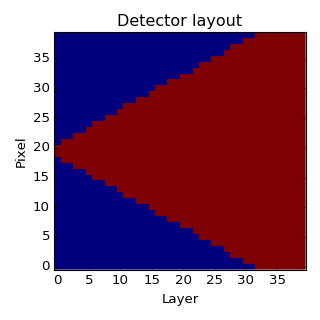

In [4]:
# Visualize the detector layout
plt.figure(figsize=(4,4))
draw_event(det_mask, title='Detector layout')

## Generate the data

Single-track signals, with track and noise backgrounds

In [5]:
# Config
num_events = 100000
num_bkg_tracks = 2
noise_prob = 0.01
num_seed_layers = 5

In [6]:
# Generate signal tracks in the masked region
sig_tracks = generate_straight_tracks(
    num_events, det_shape,
    entry_range=mask_ranges[0], exit_range=mask_ranges[-1])

# Generate backgrounds
bkg_tracks = generate_track_bkg(num_events, det_shape,
                                tracks_per_event=num_bkg_tracks,
                                skip_layers=num_seed_layers)
bkg_tracks[bkg_tracks>1] = 1
noise = generate_uniform_noise(num_events, det_shape, prob=noise_prob)

# Combine into full events
events = sig_tracks + bkg_tracks + noise
events[events > 1] = 1

# Mask the data
masked_sig_tracks = apply_det_mask(sig_tracks, det_mask)
masked_events = apply_det_mask(events, det_mask)

## Train the model

In [7]:
# Config
num_hidden = 50
batch_size = 200
num_epoch = 30
valid_frac = 0.2

# Build and train the model
model = build_model(mask_shapes, hidden_size=num_hidden)
history = model.fit(masked_events[:-1], masked_sig_tracks[1:],
                    batch_size=batch_size, nb_epoch=num_epoch,
                    validation_split=valid_frac)

Train on 80000 samples, validate on 20000 samples
Epoch 1/30
80000/80000 [==============================] - 65s - loss: 38.2384 - Layer_0_loss: 0.8078 - Layer_1_loss: 0.8093 - Layer_2_loss: 0.8352 - Layer_3_loss: 0.7740 - Layer_4_loss: 0.7442 - Layer_5_loss: 0.7392 - Layer_6_loss: 0.7749 - Layer_7_loss: 0.7786 - Layer_8_loss: 0.8060 - Layer_9_loss: 0.7901 - Layer_10_loss: 0.8283 - Layer_11_loss: 0.8443 - Layer_12_loss: 0.8696 - Layer_13_loss: 0.8778 - Layer_14_loss: 0.8949 - Layer_15_loss: 0.9072 - Layer_16_loss: 0.9227 - Layer_17_loss: 0.9515 - Layer_18_loss: 0.9883 - Layer_19_loss: 0.9818 - Layer_20_loss: 0.9930 - Layer_21_loss: 0.9948 - Layer_22_loss: 1.0352 - Layer_23_loss: 1.0394 - Layer_24_loss: 1.0735 - Layer_25_loss: 1.0804 - Layer_26_loss: 1.1054 - Layer_27_loss: 1.0890 - Layer_28_loss: 1.1071 - Layer_29_loss: 1.1307 - Layer_30_loss: 1.1525 - Layer_31_loss: 1.1484 - Layer_32_loss: 1.1750 - Layer_33_loss: 1.1488 - Layer_34_loss: 1.1837 - Layer_35_loss: 1.1834 - Layer_36_loss: 1

In [8]:
# Get the predictions on the full training set
train_preds = model.predict(masked_events[:-1], batch_size=5000)

In [9]:
# Pad the output to the correct shape
first_layer = np.zeros((train_preds[0].shape[0], mask_shapes[0]))
pad_train_preds = [first_layer] + train_preds

# Convert output to fixed size form
unmasked_train_preds = expand_masked_data(pad_train_preds, det_mask)
print('Shape of prediction:', unmasked_train_preds.shape)

Shape of prediction: (100000, 40, 40)


<IPython.core.display.Javascript object>


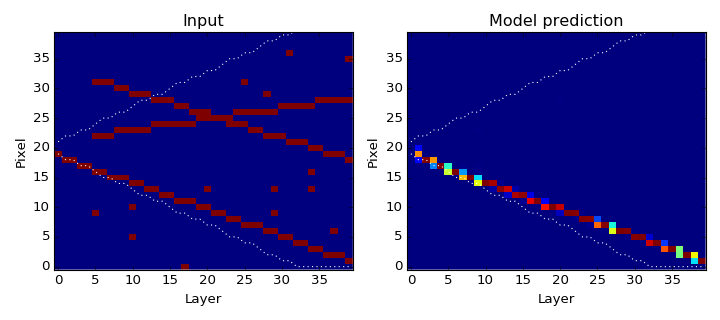

<IPython.core.display.Javascript object>


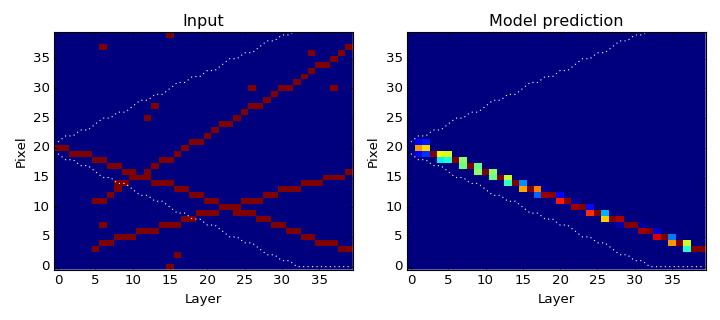

<IPython.core.display.Javascript object>


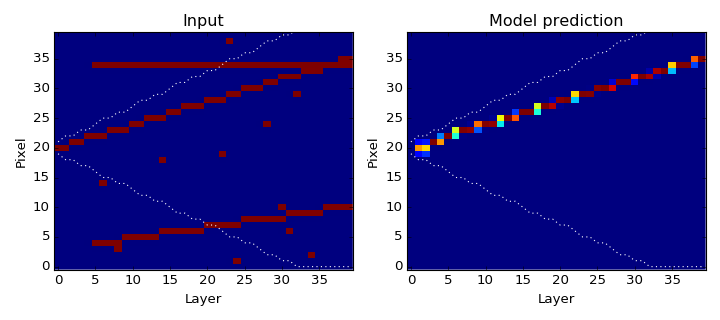

<IPython.core.display.Javascript object>


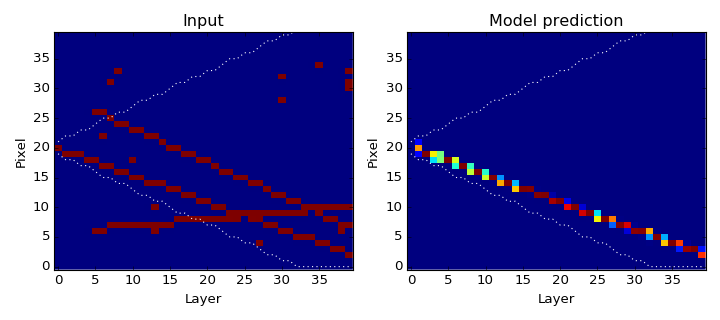

In [14]:
# Visualize some of the events
idx = 0
draw_input_and_pred(events[idx], unmasked_train_preds[idx], mask_ranges=mask_ranges)
idx = 10
draw_input_and_pred(events[idx], unmasked_train_preds[idx], mask_ranges=mask_ranges)
idx = 200
draw_input_and_pred(events[idx], unmasked_train_preds[idx], mask_ranges=mask_ranges)
idx = 3000
draw_input_and_pred(events[idx], unmasked_train_preds[idx], mask_ranges=mask_ranges)

## Training analysis

In [11]:
def draw_train_history(history, figsize=(9.5,5)):
    """Make plots of training and validation losses and accuracies"""
    plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Plot accuracies
    plt.subplot(122)
    keys = ['Layer_0_acc', 'val_Layer_0_acc',
            'Layer_20_acc', 'val_Layer_20_acc',
            'Layer_38_acc', 'val_Layer_38_acc']
    for k in keys:
        label = k.replace('_acc', '').replace('_', ' ')
        plt.plot(history.epoch, history.history[k], label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.legend(loc=0)

<IPython.core.display.Javascript object>


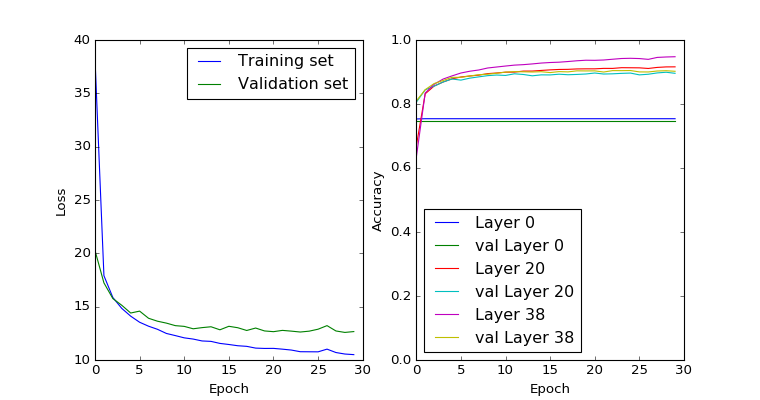

In [12]:
draw_train_history(history)

In [13]:
print('done!!!!')

done!!!!
